<a href="https://colab.research.google.com/github/hazem1379/Coursera_Capstone/blob/main/Dubai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
!conda install -c conda-forge folium=0.5.0 --yes 

import numpy as np 

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
%matplotlib inline 
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
mpl.style.use('ggplot') # optional: for ggplot-like style

# check for latest version of Matplotlib
print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

print('Libraries imported.')

/bin/bash: conda: command not found
Matplotlib version:  3.2.2
Libraries imported.



The aim of this notebook is to explore the surrounding area of some well-known attractive sites in Duba. We will use Four Square API to explore the area around the places under study.

Step 1 - download data

In [57]:
!wget https://raw.githubusercontent.com/hazem1379/Coursera_Capstone/main/Dubai_New.csv

--2021-08-05 13:47:05--  https://raw.githubusercontent.com/hazem1379/Coursera_Capstone/main/Dubai_New.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 171 [text/plain]
Saving to: ‘Dubai_New.csv.1’

Dubai_New.csv.1     100%[===================>]     171  --.-KB/s    in 0s      

2021-08-05 13:47:06 (2.74 MB/s) - ‘Dubai_New.csv.1’ saved [171/171]



In [58]:
dubai_data = pd.read_csv('/content/Dubai_New.csv', error_bad_lines=False)
dubai_data.head()


,Place,Latitude,Longitude
0,Burj Khalifa,25.208038,55.264789
1,Global Village,25.073706,55.307121
2,Dubai Airport,25.252665,55.354699
3,JBR,25.078107,55.136605


In [59]:
dubai_data.rename(columns={'lat': 'Latitude', 'lng': 'Longitude'}, inplace=True)

# **Step** 2 - Location Placement on the map of Dubai

In [60]:
# Localise places on the map of Dubai
address = 'Dubai, AE'

geolocator = Nominatim(user_agent="my-application")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Dubai are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Dubai are 25.074282349999997, 55.18853865430702.


In [61]:
# create map of Dubai using latitude and longitude values
map_dubai = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, label in zip(dubai_data['Latitude'], dubai_data['Longitude'], dubai_data['Place']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=10,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_dubai)  
    
map_dubai

In [62]:
#Define Foursquare Credentials and Version
CLIENT_ID = 'OA2SAKXHQX4QEOGP1MZ5RYWS5T40OXO1L1VWUXL05UR50N4Y' # your Foursquare ID
CLIENT_SECRET = 'SPYSR1EVSZ53044I0HQB2JRP5OYNZEULWOGT4LDVLWVMD2OL' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: OA2SAKXHQX4QEOGP1MZ5RYWS5T40OXO1L1VWUXL05UR50N4Y
CLIENT_SECRET:SPYSR1EVSZ53044I0HQB2JRP5OYNZEULWOGT4LDVLWVMD2OL



Explore the city

In [63]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=200):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng,            
            v['venue']['name'], 
            v['venue']['id'],
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Place', 
                  'PlaceLatitude', 
                  'PlaceLongitude', 
                  'Venue',
                  'Venue id',                
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category'
                             
                   ]
    
    return(nearby_venues)

step 3 - Rating of Venue

In [64]:
# test rating
# Burj Khalifa 4adcda10f964a520af3521e3
# Global Village 4adcda09f964a520e83321e3
# Dubai Airportrt 51a2445e5019c80b56934c75
# JBR4a520de3321e3

venue_id ={
    'Burj Khalifa': '4b94f4f8f964a5204b8934e3',
    'Global Village': 'b4f73d7f964a520430727e3',
    'Dubai Airport': '59d716e49b04736749cf02db',
    'The Walk at JBR': 'b9a90dcf964a520dfc135e3'
}

for key,value in venue_id.items():
    
    url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(value, CLIENT_ID, CLIENT_SECRET, VERSION)
    result = requests.get(url).json()
    try:
        print('Venue :', key)
        print('Rating : ', result['response']['venue']['rating'])
        print('Total Tips : ', result['response']['venue']['tips']['count'])
        print('Nb Likes : ', result['response']['venue']['tips']['groups'][0]['items'][0]['likes']['count'])
        print('Nb Likes / Total Tips', (result['response']['venue']['tips']['groups'][0]['items'][0]['likes']['count'])/ (result['response']['venue']['tips']['count']) *100 )
        
        print()

    except:
        print('This venue has not been rated yet.')

Venue : Burj Khalifa
This venue has not been rated yet.
Venue : Global Village
This venue has not been rated yet.
Venue : Dubai Airport
This venue has not been rated yet.
Venue : The Walk at JBR
This venue has not been rated yet.


Step 4 - Category of Venue

In [65]:
dubai_data_venues = getNearbyVenues(names=dubai_data['Place'],
                                   latitudes=dubai_data['Latitude'],
                                   longitudes=dubai_data['Longitude']
                                  )
#print(dubai_data_venues.shape)
dubai_data_venues

Burj Khalifa
Global Village
Dubai Airport
JBR


,Place,PlaceLatitude,PlaceLongitude,Venue,Venue id,Venue Latitude,Venue Longitude,Venue Category
0,Burj Khalifa,25.208038,55.264789,The Roxy Cinemas,589dfabb84677a520fe72337,25.207183,55.263502,Movie Theater
1,Burj Khalifa,25.208038,55.264789,Urth Caffe (إيرث كافيه),5bd0124b27cbd100253a33c0,25.208221,55.263431,Café
2,Burj Khalifa,25.208038,55.264789,Sarabeth’s,58d11212d2433261703ba918,25.207246,55.265437,Breakfast Spot
3,Burj Khalifa,25.208038,55.264789,Mitts & Trays Restaurant and Cafe,57af45aecd1064459f43df46,25.208034,55.262896,Restaurant
4,Burj Khalifa,25.208038,55.264789,The Roxy Cinema Director's Lounge,586e56629343e030f2d7ee08,25.207304,55.262945,Movie Theater
5,Burj Khalifa,25.208038,55.264789,Mattel Play Town,57495e2e498e31fbc59fa480,25.207725,55.262310,Indoor Play Area
6,Burj Khalifa,25.208038,55.264789,City Walk (سيتي ووك),5268acfb498e429bde00775b,25.207284,55.262279,Shopping Plaza
7,Burj Khalifa,25.208038,55.264789,The Roxy Cinema Editor's Suite,58e54754db6cd626309fd00b,25.207153,55.263412,Movie Theater
8,Burj Khalifa,25.208038,55.264789,Hub Zero,54b5298a498eb7bad660bc95,25.206940,55.262489,Arcade
9,Burj Khalifa,25.208038,55.264789,Concept Store LE66,584be1d218fd2b05b6818689,25.207863,55.263788,Clothing Store


Count

In [66]:
# More intersting
#Let's check how many venues were returned for each place
dubai_data_venues.groupby('Place').count()

,PlaceLatitude,PlaceLongitude,Venue,Venue id,Venue Latitude,Venue Longitude,Venue Category
Place,,,,,,,
Burj Khalifa,41,41,41,41,41,41,41
Dubai Airport,37,37,37,37,37,37,37
Global Village,19,19,19,19,19,19,19
JBR,100,100,100,100,100,100,100


Step 5 - Histogramme

In [67]:
df_view_new = dubai_data_venues.groupby('Place').count()
df_dubai_histo = df_view_new['Venue Category']
df_dubai_histo

Place
Burj Khalifa       41
Dubai Airport      37
Global Village     19
JBR               100
Name: Venue Category, dtype: int64

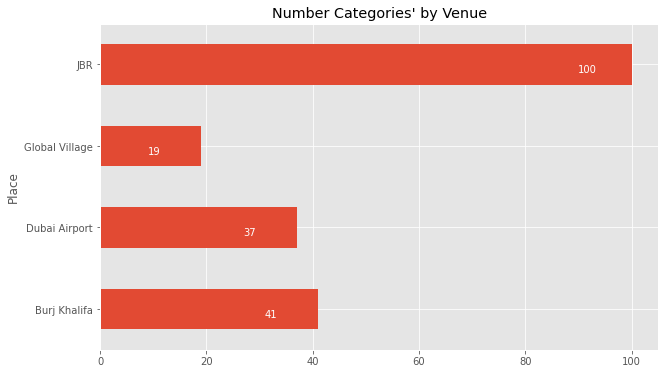

In [68]:
df_dubai_histo.plot(kind='barh', figsize=(10,6))

#plt.xlabel('name') # add to x-label to the plot
#plt.ylabel('Number de categories') # add y-label to the plot
plt.title('Number Categories\' by Venue') # add title to the plot

for index, value in enumerate(df_dubai_histo): 
    label = format(int(value), ',') 
    plt.annotate(label, xy=(value - 10, index - 0.10), color='white')
    
plt.show()

Step 6 - Analyse for each Categories


In [69]:
#Analyze Each Place
# one hot encoding
dubai_onehot = pd.get_dummies(dubai_data_venues[['Venue Category']], prefix="", prefix_sep="")

# add Placecolumn back to dataframe
dubai_onehot['Place'] = dubai_data_venues['Place'] 

# move Placecolumn to the first column
fixed_columns = [dubai_onehot.columns[-1]] + list(dubai_onehot.columns[:-1])
dubai_onehot = dubai_onehot[fixed_columns]

dubai_onehot

,Place,Airport,Airport Lounge,Airport Service,American Restaurant,Arcade,Asian Restaurant,BBQ Joint,Bakery,Bar,Beach,Beach Bar,Bistro,Botanical Garden,Breakfast Spot,Burger Joint,Café,Caribbean Restaurant,Chocolate Shop,Churrascaria,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop,Duty-free Shop,English Restaurant,Falafel Restaurant,Fast Food Restaurant,Flea Market,Food Court,Grocery Store,Gym,Gym / Fitness Center,Halal Restaurant,Hotel,Hotel Pool,Ice Cream Shop,Indian Restaurant,Indoor Play Area,Irish Pub,Italian Restaurant,Japanese Restaurant,Lebanese Restaurant,Lounge,Mediterranean Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Movie Theater,Multiplex,Night Market,Pharmacy,Pizza Place,Plaza,Pool,Pub,Rental Car Location,Restaurant,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Shopping Mall,Shopping Plaza,Smoke Shop,Spa,Sports Bar,Steakhouse,Supermarket,Theater,Theme Park,Theme Park Ride / Attraction,Toy / Game Store,Trail,Tram Station,Tunnel,Turkish Restaurant,Wine Bar
0,Burj Khalifa,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Burj Khalifa,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Burj Khalifa,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Burj Khalifa,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Burj Khalifa,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,Burj Khalifa,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,Burj Khalifa,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,Burj Khalifa,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,Burj Khalifa,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,Burj Khalifa,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [70]:

# let's group rows by Place
# and by taking the mean 
dubai_grouped = dubai_onehot.groupby('Place').mean().reset_index()
dubai_grouped

,Place,Airport,Airport Lounge,Airport Service,American Restaurant,Arcade,Asian Restaurant,BBQ Joint,Bakery,Bar,Beach,Beach Bar,Bistro,Botanical Garden,Breakfast Spot,Burger Joint,Café,Caribbean Restaurant,Chocolate Shop,Churrascaria,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop,Duty-free Shop,English Restaurant,Falafel Restaurant,Fast Food Restaurant,Flea Market,Food Court,Grocery Store,Gym,Gym / Fitness Center,Halal Restaurant,Hotel,Hotel Pool,Ice Cream Shop,Indian Restaurant,Indoor Play Area,Irish Pub,Italian Restaurant,Japanese Restaurant,Lebanese Restaurant,Lounge,Mediterranean Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Movie Theater,Multiplex,Night Market,Pharmacy,Pizza Place,Plaza,Pool,Pub,Rental Car Location,Restaurant,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Shopping Mall,Shopping Plaza,Smoke Shop,Spa,Sports Bar,Steakhouse,Supermarket,Theater,Theme Park,Theme Park Ride / Attraction,Toy / Game Store,Trail,Tram Station,Tunnel,Turkish Restaurant,Wine Bar
0,Burj Khalifa,0.000000,0.000000,0.000000,0.02439,0.04878,0.00,0.00,0.048780,0.024390,0.00,0.00,0.02439,0.02439,0.048780,0.048780,0.121951,0.00,0.02439,0.00,0.02439,0.00,0.073171,0.00,0.02439,0.000000,0.02439,0.000000,0.00,0.00,0.024390,0.000000,0.000000,0.00,0.00,0.00,0.000000,0.02439,0.00,0.02439,0.024390,0.02439,0.000000,0.00,0.00,0.00,0.00,0.02439,0.000000,0.00,0.073171,0.00,0.000000,0.00,0.02439,0.00,0.00,0.00,0.000000,0.048780,0.00,0.000000,0.00,0.00,0.02439,0.000000,0.000000,0.00,0.02439,0.00,0.000000,0.000000,0.00,0.04878,0.00,0.00,0.000000,0.000000,0.02439
1,Dubai Airport,0.027027,0.135135,0.162162,0.00000,0.00000,0.00,0.00,0.027027,0.027027,0.00,0.00,0.00000,0.00000,0.027027,0.000000,0.054054,0.00,0.00000,0.00,0.00000,0.00,0.135135,0.00,0.00000,0.000000,0.00000,0.027027,0.00,0.00,0.054054,0.000000,0.027027,0.00,0.00,0.00,0.000000,0.00000,0.00,0.00000,0.027027,0.00000,0.027027,0.00,0.00,0.00,0.00,0.00000,0.054054,0.00,0.000000,0.00,0.000000,0.00,0.00000,0.00,0.00,0.00,0.054054,0.000000,0.00,0.054054,0.00,0.00,0.00000,0.027027,0.027027,0.00,0.00000,0.00,0.000000,0.000000,0.00,0.00000,0.00,0.00,0.027027,0.000000,0.00000
2,Global Village,0.000000,0.000000,0.000000,0.00000,0.00000,0.00,0.00,0.000000,0.000000,0.00,0.00,0.00000,0.00000,0.000000,0.052632,0.000000,0.00,0.00000,0.00,0.00000,0.00,0.052632,0.00,0.00000,0.052632,0.00000,0.000000,0.00,0.00,0.052632,0.473684,0.000000,0.00,0.00,0.00,0.052632,0.00000,0.00,0.00000,0.000000,0.00000,0.000000,0.00,0.00,0.00,0.00,0.00000,0.000000,0.00,0.000000,0.00,0.052632,0.00,0.00000,0.00,0.00,0.00,0.000000,0.052632,0.00,0.000000,0.00,0.00,0.00000,0.000000,0.000000,0.00,0.00000,0.00,0.052632,0.052632,0.00,0.00000,0.00,0.00,0.000000,0.052632,0.00000
3,JBR,0.000000,0.000000,0.000000,0.00000,0.00000,0.01,0.01,0.020000,0.020000,0.02,0.01,0.01000,0.00000,0.040000,0.030000,0.050000,0.01,0.00000,0.01,0.00000,0.02,0.130000,0.01,0.00000,0.010000,0.01000,0.000000,0.01,0.01,0.020000,0.000000,0.000000,0.01,0.01,0.01,0.000000,0.13000,0.01,0.02000,0.020000,0.00000,0.000000,0.02,0.01,0.01,0.04,0.00000,0.010000,0.01,0.010000,0.02,0.000000,0.01,0.01000,0.01,0.01,0.01,0.000000,0.030000,0.02,0.000000,0.01,0.02,0.00000,0.000000,0.010000,0.01,0.00000,0.02,0.000000,0.000000,0.01,0.00000,0.01,0.01,0.000000,0.000000,0.00000


# The top 10 most common venues

In [71]:

#Let's print each Place along with the top 10 most common venues
num_top_venues = 10

for hood in dubai_grouped['Place']:
    print("----"+hood+"----")
    temp = dubai_grouped[dubai_grouped['Place'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Burj Khalifa----
               venue  freq
0               Café  0.12
1      Movie Theater  0.07
2        Coffee Shop  0.07
3     Breakfast Spot  0.05
4   Toy / Game Store  0.05
5             Arcade  0.05
6         Restaurant  0.05
7             Bakery  0.05
8       Burger Joint  0.05
9  Indian Restaurant  0.02


----Dubai Airport----
                       venue  freq
0            Airport Service  0.16
1             Airport Lounge  0.14
2                Coffee Shop  0.14
3                       Café  0.05
4             Sandwich Place  0.05
5        Rental Car Location  0.05
6  Middle Eastern Restaurant  0.05
7       Fast Food Restaurant  0.05
8                    Airport  0.03
9                     Tunnel  0.03


----Global Village----
                  venue  freq
0           Flea Market  0.47
1           Coffee Shop  0.05
2               Theater  0.05
3  Fast Food Restaurant  0.05
4          Burger Joint  0.05
5          Night Market  0.05
6     Convenience Store  0.05
7      H

In [72]:
#Let's put that into a pandas dataframe
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [73]:
#Now let's create the new dataframe 
#and display the top 10 venues for each Place.
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Place']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
place_venues_sorted = pd.DataFrame(columns=columns)
place_venues_sorted['Place'] = dubai_grouped['Place']

for ind in np.arange(dubai_grouped.shape[0]):
    place_venues_sorted.iloc[ind, 1:] = return_most_common_venues(dubai_grouped.iloc[ind, :], num_top_venues)

place_venues_sorted

,Place,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Burj Khalifa,Café,Movie Theater,Coffee Shop,Arcade,Bakery,Toy / Game Store,Restaurant,Breakfast Spot,Burger Joint,Cosmetics Shop
1,Dubai Airport,Airport Service,Airport Lounge,Coffee Shop,Café,Sandwich Place,Fast Food Restaurant,Middle Eastern Restaurant,Rental Car Location,Food Court,Indian Restaurant
2,Global Village,Flea Market,Convenience Store,Turkish Restaurant,Coffee Shop,Halal Restaurant,Restaurant,Theme Park,Theater,Fast Food Restaurant,Night Market
3,JBR,Coffee Shop,Hotel,Café,Breakfast Spot,Lounge,Burger Joint,Restaurant,Bar,Fast Food Restaurant,Indian Restaurant


Step 7 - Search by Interest's Venues with Clusters method

In [74]:
# set number of clusters
kclusters = 4

dubai_grouped_clustering = dubai_grouped.drop('Place', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(dubai_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 2, 1, 3], dtype=int32)

In [75]:
#Let's create a new dataframe that includes the cluster as well as the top 10 venues for each Place.

dubai_merged = dubai_data

# add clustering labels
dubai_merged['Cluster Labels'] = kmeans.labels_

dubai_merged = dubai_merged.join(place_venues_sorted.set_index('Place'), on='Place')
dubai_merged 
# check the last columns!

,Place,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Burj Khalifa,25.208038,55.264789,0,Café,Movie Theater,Coffee Shop,Arcade,Bakery,Toy / Game Store,Restaurant,Breakfast Spot,Burger Joint,Cosmetics Shop
1,Global Village,25.073706,55.307121,2,Flea Market,Convenience Store,Turkish Restaurant,Coffee Shop,Halal Restaurant,Restaurant,Theme Park,Theater,Fast Food Restaurant,Night Market
2,Dubai Airport,25.252665,55.354699,1,Airport Service,Airport Lounge,Coffee Shop,Café,Sandwich Place,Fast Food Restaurant,Middle Eastern Restaurant,Rental Car Location,Food Court,Indian Restaurant
3,JBR,25.078107,55.136605,3,Coffee Shop,Hotel,Café,Breakfast Spot,Lounge,Burger Joint,Restaurant,Bar,Fast Food Restaurant,Indian Restaurant


## **Visualisation**

In [76]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**3 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(dubai_merged['Latitude'], dubai_merged['Longitude'], dubai_merged['Place'], dubai_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=20,
        popup=label,
        color='black',
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Cluster 0 : Burj Khalifa

In [77]:
dubai_merged.loc[dubai_merged['Cluster Labels'] == 0, dubai_merged.columns[[1] + list(range(5, dubai_merged.shape[1]))]]

,Latitude,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,25.208038,Movie Theater,Coffee Shop,Arcade,Bakery,Toy / Game Store,Restaurant,Breakfast Spot,Burger Joint,Cosmetics Shop


Cluster 1 :  Dubai Airport 


In [78]:
dubai_merged.loc[dubai_merged['Cluster Labels'] == 1, dubai_merged.columns[[1] + list(range(5, dubai_merged.shape[1]))]]

,Latitude,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,25.252665,Airport Lounge,Coffee Shop,Café,Sandwich Place,Fast Food Restaurant,Middle Eastern Restaurant,Rental Car Location,Food Court,Indian Restaurant


Cluster 2 : Global Village

In [79]:
dubai_merged.loc[dubai_merged['Cluster Labels'] == 2, dubai_merged.columns[[1] + list(range(5, dubai_merged.shape[1]))]]

,Latitude,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,25.073706,Convenience Store,Turkish Restaurant,Coffee Shop,Halal Restaurant,Restaurant,Theme Park,Theater,Fast Food Restaurant,Night Market



Cluster 3 : JBR

In [80]:
dubai_merged.loc[dubai_merged['Cluster Labels'] == 3, dubai_merged.columns[[1] + list(range(5, dubai_merged.shape[1]))]]

,Latitude,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,25.078107,Hotel,Café,Breakfast Spot,Lounge,Burger Joint,Restaurant,Bar,Fast Food Restaurant,Indian Restaurant



Step 8 - View on particular Venue : JBR

In [81]:
#Get the Placelatitude and longitude values.
place_latitude = dubai_data.loc[3, 'Latitude'] # Placelatitude value
place_longitude = dubai_data.loc[3, 'Longitude'] # Place longitude value

place_name = dubai_data.loc[3, 'Place'] # Placename

print('Latitude and longitude values of {} are {}, {}.'.format(place_name, 
                                                               place_latitude, 
                                                               place_longitude))

Latitude and longitude values of JBR are 25.07810732, 55.13660532.


In [82]:
#First, let's create the GET request URL. Name your URL url.
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID,CLIENT_SECRET,VERSION,place_latitude,place_longitude,radius,LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=OA2SAKXHQX4QEOGP1MZ5RYWS5T40OXO1L1VWUXL05UR50N4Y&client_secret=SPYSR1EVSZ53044I0HQB2JRP5OYNZEULWOGT4LDVLWVMD2OL&v=20180605&ll=25.07810732,55.13660532&radius=500&limit=100'

In [83]:
#Send the GET request and examine the resutls
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '610bebdd490ad63ecb67d049'},
 'response': {'groups': [{'items': [{'reasons': {'count': 0,
       'items': [{'reasonName': 'globalInteractionReason',
         'summary': 'This spot is popular',
         'type': 'general'}]},
      'referralId': 'e-0-53f51e8e11d2ae83c40a6d1c-0',
      'venue': {'categories': [{'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/travel/hotel_',
          'suffix': '.png'},
         'id': '4bf58dd8d48988d1fa931735',
         'name': 'Hotel',
         'pluralName': 'Hotels',
         'primary': True,
         'shortName': 'Hotel'}],
       'id': '53f51e8e11d2ae83c40a6d1c',
       'location': {'address': 'Dubai Marina',
        'cc': 'AE',
        'city': 'دبي',
        'country': 'الإمارات العربية المتحدة',
        'distance': 140,
        'formattedAddress': ['Dubai Marina',
         'دبي',
         'الإمارات العربية المتحدة'],
        'labeledLatLngs': [{'label': 'display',
          'lat': 25.079065020390953,
  

In [84]:
# def Categories with Foursquare Type
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [85]:
# determine Venues 
# Now we are ready to clean the json and structure it into a pandas dataframe.
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng', 'venue.id']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  """


,name,categories,lat,lng,id
0,InterContinental Dubai Marina,Hotel,25.079065,55.137516,53f51e8e11d2ae83c40a6d1c
1,JA Oasis Beach Tower (فندق برج شاطئ الواحة جي ...,Hotel,25.079777,55.136056,4d7b222273ca5481c37c467c
2,Hilton Dubai The Walk,Hotel,25.078054,55.134936,52a34226498ed0e56bb53f34
3,The Walk at JBR (الممشى في الجي بي آر),Plaza,25.077780,55.133824,4b9a90dcf964a520dfc135e3
4,Starbucks (ستاربكس),Coffee Shop,25.076615,55.135227,4b3b3bfef964a520ae7125e3
5,La Sirene Hair Beauty & Spa,Salon / Barbershop,25.079781,55.136193,4bb1c031f964a5207ea13ce3
6,Luigia,Italian Restaurant,25.079930,55.135892,5a4e58e33d479178c38e0e36
7,Fogueira,Churrascaria,25.077676,55.136062,508996abe4b0b69fe6e52367
8,Pier 7,Restaurant,25.076871,55.139215,51978473498e459555323a3d
9,Sama Lounge,Lounge,25.077923,55.135808,50a3e7d7e4b08f00ef701226


In [86]:
venue_id = '4b94f4f8f964a5204b8934e3' # Dubai Airport 51a2445e5019c80b56934c75
url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)

result = requests.get(url).json()
try:
    print('Rating : ', result['response']['venue']['rating'])
    print('Total Tips : ', result['response']['venue']['tips']['count'])
    print('Nb Likes : ', result['response']['venue']['tips']['groups'][0]['items'][0]['likes']['count'])
    print('Nb Likes / Total Tips', (result['response']['venue']['tips']['groups'][0]['items'][0]['likes']['count'])/ (result['response']['venue']['tips']['count']) *100 )
except:
    print('This venue has not been rated yet.')

This venue has not been rated yet.


Look at Tips and text


In [87]:
## Ecco Tips
venue_id = '4b94f4f8f964a5204b8934e3'
limit = 200 # set limit to be greater than or equal to the total number of tips
url = 'https://api.foursquare.com/v2/venues/{}/tips?client_id={}&client_secret={}&v={}&limit={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION, limit)

results = requests.get(url).json()
results

{'meta': {'code': 429,
  'errorDetail': 'Quota exceeded',
  'errorType': 'quota_exceeded',
  'requestId': '610bebdea4a98f0753f348e6'},
 'response': {}}

In [88]:
# test opinion Place
tips = results['response']['tips']['items']

tip = results['response']['tips']['items'][0]
tip.keys()

KeyError: ignored

In [89]:
###pd.set_option('display.max_colwidth', -1)

###tips_df = json_normalize(tips) # json normalize tips

# columns to keep
###filtered_columns = ['text', 'agreeCount', 'disagreeCount', 'id', 'user.firstName', 'user.lastName', 'user.gender', 'user.id']
###tips_filtered = tips_df.loc[:, filtered_columns]

# display tips
###tips_filtered


Step 9 - Research of Spots to this venue : Global Village

In [90]:
#First, let's create the GET request URL. Name your URL url.
LIMIT = 150 # limit of number of venues returned by Foursquare API
radius = 1000 # define radius

url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?client_id=OA2SAKXHQX4QEOGP1MZ5RYWS5T40OXO1L1VWUXL05UR50N4Y&client_secret=SPYSR1EVSZ53044I0HQB2JRP5OYNZEULWOGT4LDVLWVMD2OL&ll=25.074282349999997,55.18853865430702&v=20180605&radius=1000&limit=150'

In [91]:
results = requests.get(url).json()
'There are {} popular spots around.'.format(len(results['response']['groups'][0]['items']))

'There are 12 popular spots around.'

In [92]:
items = results['response']['groups'][0]['items']
items[0]

{'reasons': {'count': 0,
  'items': [{'reasonName': 'globalInteractionReason',
    'summary': 'This spot is popular',
    'type': 'general'}]},
 'referralId': 'e-0-4c2efa3766e40f47ea2dc18b-0',
 'venue': {'categories': [{'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/salon_barber_',
     'suffix': '.png'},
    'id': '4bf58dd8d48988d110951735',
    'name': 'Salon / Barbershop',
    'pluralName': 'Salons / Barbershops',
    'primary': True,
    'shortName': 'Salon / Barbershop'}],
  'id': '4c2efa3766e40f47ea2dc18b',
  'location': {'cc': 'AE',
   'city': 'دبي',
   'country': 'الإمارات العربية المتحدة',
   'distance': 944,
   'formattedAddress': ['دبي', 'الإمارات العربية المتحدة'],
   'labeledLatLngs': [{'label': 'display',
     'lat': 25.066437138803238,
     'lng': 55.192110885743894}],
   'lat': 25.066437138803238,
   'lng': 55.192110885743894,
   'state': 'دبي'},
  'name': 'Tips & Toes Springs',
  'photos': {'count': 0, 'groups': []}}}

In [93]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [94]:
dataframe = json_normalize(items) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories'] + [col for col in dataframe.columns if col.startswith('venue.location.')] + ['venue.id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# filter the category for each row
dataframe_filtered['venue.categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean columns
dataframe_filtered.columns = [col.split('.')[-1] for col in dataframe_filtered.columns]

dataframe_filtered.head(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  """Entry point for launching an IPython kernel.


,name,categories,lat,lng,labeledLatLngs,distance,cc,city,state,country,formattedAddress,address,crossStreet,id
0,Tips & Toes Springs,Salon / Barbershop,25.066437,55.192111,"[{'label': 'display', 'lat': 25.06643713880323...",944,AE,دبي,دبي,الإمارات العربية المتحدة,"[دبي, الإمارات العربية المتحدة]",NaN,NaN,4c2efa3766e40f47ea2dc18b
1,Xenia DXB,Mediterranean Restaurant,25.066483,55.191847,"[{'label': 'display', 'lat': 25.066483, 'lng':...",930,AE,دبي,دبي,الإمارات العربية المتحدة,"[Spring Souq, دبي, الإمارات العربية المتحدة]",Spring Souq,NaN,5c16367f46e1b6002c337a97
2,Le Pain Quotidien,Breakfast Spot,25.066097,55.192052,"[{'label': 'display', 'lat': 25.066097, 'lng':...",977,AE,دبي,دبي,الإمارات العربية المتحدة,"[Al Afnan St, دبي, الإمارات العربية المتحدة]",NaN,Al Afnan St,5b2cd85781a0ea002ca22fe0
3,Carluccio's - The Springs Souks,Italian Restaurant,25.066379,55.191842,"[{'label': 'display', 'lat': 25.066379, 'lng':...",940,AE,دبي,دبي,الإمارات العربية المتحدة,"[The Springs Souk, Ground Floor, Al Afnan Stre...","The Springs Souk, Ground Floor, Al Afnan Stree...",NaN,5d0cff74c626c60024acc888
4,The Town Centre,Convenience Store,25.066375,55.192035,"[{'label': 'display', 'lat': 25.06637459956527...",948,AE,دبي,دبي,الإمارات العربية المتحدة,"[Springs, دبي, الإمارات العربية المتحدة]",Springs,NaN,4d20b8fe756e8cfa53e66e54
5,Asia Tang,Asian Restaurant,25.066329,55.192056,"[{'label': 'display', 'lat': 25.066329, 'lng':...",953,AE,The Springs,دبي,الإمارات العربية المتحدة,"[The Springs, الإمارات العربية المتحدة]",NaN,NaN,5b48b0ff28374e002c54a9ef
6,The Coffee Club,Coffee Shop,25.066055,55.192165,"[{'label': 'display', 'lat': 25.066055, 'lng':...",986,AE,دبي,دبي,الإمارات العربية المتحدة,"[Al Afnan St, دبي, الإمارات العربية المتحدة]",NaN,Al Afnan St,5b364ab666f3cd003908cb27
7,Springs 6,Park,25.068680,55.188343,"[{'label': 'display', 'lat': 25.06868030234028...",623,AE,دبي,دبي,الإمارات العربية المتحدة,"[دبي, الإمارات العربية المتحدة]",NaN,NaN,4b8662d3f964a520388831e3
8,Beyond the Beach,Board Shop,25.068107,55.192646,"[{'label': 'display', 'lat': 25.06810742022395...",802,AE,دبي,دبي,الإمارات العربية المتحدة,"[@ Springs Town Centre, دبي, الإمارات العربية ...",@ Springs Town Centre,NaN,4cd6cb71ab19a0930dd946eb
9,BinSina Pharmacy Spring Village Mall,Pharmacy,25.066036,55.191419,"[{'label': 'display', 'lat': 25.0660361, 'lng'...",962,AE,دبي,دبي,الإمارات العربية المتحدة,"[Al Afnan Street, Spring Village Mall, Springs...","Al Afnan Street, Spring Village Mall, Springs 7",NaN,5baf19bfda5ede00392c67ff


In [95]:
newTest = dataframe_filtered[['name', 'categories']]
newTest

,name,categories
0,Tips & Toes Springs,Salon / Barbershop
1,Xenia DXB,Mediterranean Restaurant
2,Le Pain Quotidien,Breakfast Spot
3,Carluccio's - The Springs Souks,Italian Restaurant
4,The Town Centre,Convenience Store
5,Asia Tang,Asian Restaurant
6,The Coffee Club,Coffee Shop
7,Springs 6,Park
8,Beyond the Beach,Board Shop
9,BinSina Pharmacy Spring Village Mall,Pharmacy


In [96]:
# Some activities
print(dataframe_filtered.categories.unique())

['Salon / Barbershop' 'Mediterranean Restaurant' 'Breakfast Spot'
 'Italian Restaurant' 'Convenience Store' 'Asian Restaurant' 'Coffee Shop'
 'Park' 'Board Shop' 'Pharmacy' 'Ice Cream Shop']



Visualisation with Word Cloud

In [97]:
## word clouds 
!conda install -c conda-forge wordcloud==1.4.1 --yes


# import package and its set of stopwords
from wordcloud import WordCloud, STOPWORDS

print ('Wordcloud is installed and imported!')

/bin/bash: conda: command not found
Wordcloud is installed and imported!


In [98]:
newTest_words = dataframe_filtered[['categories']]
newTest_words.head()

,categories
0,Salon / Barbershop
1,Mediterranean Restaurant
2,Breakfast Spot
3,Italian Restaurant
4,Convenience Store


In [99]:
newTest_words.to_csv('myTexteTourEiffel.txt', sep=',', index=False)

In [100]:
myTest = open('myTexteTourEiffel.txt', 'r').read()

In [101]:
stopwords = set(STOPWORDS)

In [102]:
tour_eiffel_wc = WordCloud(
background_color='white',
    max_words=2000,
    stopwords=stopwords
)

tour_eiffel_wc.generate(myTest)

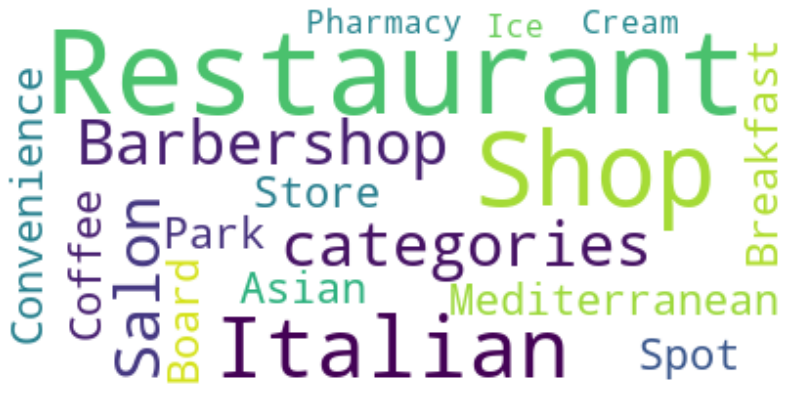

In [103]:
# display the word cloud
fig = plt.figure()
fig.set_figwidth(14) # set width
fig.set_figheight(18) # set height
plt.imshow(tour_eiffel_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

Map Visualisation


In [104]:
#Let's visualize these items on the map around our location
venues_map = folium.Map(location=[latitude, longitude], zoom_start=15) # generate map centred around Ecco

#colors = [purple, orange, darkred,lightred,beige,darkblue, darkgreen, cadetblue, darkpurple, pink, lightblue, lightgreen,lightgray]
# categories
#

# folium.Marker([lat, lon], popup=str(name)+': '+color+'-'+str(clname), icon=folium.Icon(color=color)).add_to(feature_group)

# add Ecco as a red circle mark
label = folium.Popup('JBR', parse_html=True)
folium.CircleMarker(
    [latitude, longitude],
    radius=10,
    popup=label,
    fill=True,
    color='red',
    fill_color='red',
    fill_opacity=0.6
    ).add_to(venues_map)


# add popular spots to the map as blue circle markers
for lat, lng, name, category in zip(dataframe_filtered.lat, dataframe_filtered.lng, dataframe_filtered.name, dataframe_filtered.categories):
    label = '{}, {}'.format(name, category)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=7,
        popup=label,
        fill=True,
        color= 'green',
        fill_color = 'black',
        fill_opacity=0.6
        ).add_to(venues_map)

# display map
venues_map

Step 10 - Tendance of this Venue

In [105]:
# tendances 
# define URL
url = 'https://api.foursquare.com/v2/venues/trending?client_id={}&client_secret={}&ll={},{}&v={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION)

# send GET request and get trending venues
results = requests.get(url).json()
#results

In [106]:
if len(results['response']['venues']) == 0:
    trending_venues_df = 'No trending venues are available at the moment!'
    
else:
    trending_venues = results['response']['venues']
    trending_venues_df = json_normalize(trending_venues)

    # filter columns
    columns_filtered = ['name', 'categories'] + ['location.distance', 'location.city', 'location.postalCode', 'location.state', 'location.country', 'location.lat', 'location.lng']
    trending_venues_df = trending_venues_df.loc[:, columns_filtered]

    # filter the category for each row
    trending_venues_df['categories'] = trending_venues_df.apply(get_category_type, axis=1)

In [108]:
# display trending venues
trending_venues_df

'No trending venues are available at the moment!'

Map visualisation


In [107]:
#Visualize trending venues

if len(results['response']['venues']) == 0:
    venues_map = 'Cannot generate visual as no trending venues are available at the moment!'

else:
    venues_map = folium.Map(location=[latitude, longitude], zoom_start=15) # generate map centred around Ecco


    # add Ecco as a red circle mark
    label = folium.Popup('Burj Khalifa', parse_html=True)
    folium.features.CircleMarker(
        [latitude, longitude],
        radius=15,
        popup=label,
        fill=True,
        color='red',
        fill_color='red',
        fill_opacity=0.6
    ).add_to(venues_map)


    # add the trending venues as blue circle markers
    for lat, lng, name, category in zip(trending_venues_df['location.lat'], trending_venues_df['location.lng'], trending_venues_df['name'], trending_venues_df['categories']):
        label = '{}, {}'.format(name, category)
        label = folium.Popup(label, parse_html=True)
        folium.features.CircleMarker(
            [lat, lng],
            radius=10,
            poup=label,
            fill=True,
            color='blue',
            fill_color='black',
            fill_opacity=0.6
        ).add_to(venues_map)

In [109]:
venues_map

'Cannot generate visual as no trending venues are available at the moment!'